# CS171 - Winter 2020 - Assignment 3
### Instructor: Vagelis Papalexakis
### TA: Yorgos Tsitsikas
### Credit for  Assignment 3: 15/40 points of the final grade

In this assignment we will implement the K-means clustering algorithm. We are going to use the same dataset as in the previous two assignments (<b>Note</b>: make sure you copy the dataset from Assignment 1 to the folder of this assignment!).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as rand
from sklearn.model_selection import train_test_split

data_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
data = pd.read_csv('iris.data', 
                   names = data_names)

## Question 1: Implementing and testing K-means clustering [100%]
### Question 1a: Implementing K-Means clustering [50%]
In this question you should implement a function that performs k-means clustering, using the Euclidean distance (you may use Numpy libraries for the distance computation). For calculation of the centroid you should use the 'mean' function.

For uniformity, you should implement a function with the following specifications:
```python
def kmeans_clustering(all_vals,K,max_iter = 100, tol = pow(10,-3) ):
```
where 1) 'all_vals' is the $N \times M$ matrix that contains all data points ($N$ is the number of data points and $M$ is the number of features, each row of the matrix is a data point), 2) 'K' is the number of clusters, 3) 'max_iter' is the maxium number of iterations, and 4) 'tol' is the tolerance for the change of the sum of squares of errors that determines convergence.

Your function should return the following variables: 1) 'assignments': this is a $N\times 1$ vector (where $N$ is the number of data points) where the $i$-th position of that vector contains the cluster number that the $i$-th data point is assigned to, 2) 'centroids': this is a $K\times M$ matrix, each row of which contains the centroid for every cluster, 3) 'all_sse': this is a vector that contains all the sum of squares of errors per iteration of the algorithm, and 4) 'iters': this is the number of iterations that the algorithm ran.

Here we are going to implement the simplest version of K-means, where the initial centroids are chosen entirely at random among all the data points.

As we saw in class, the K-means algorithm iterates over the following steps:
- Given a set of centroids, assign all data points to the cluster represented by its nearest centroid (according to Euclidean distance)
- Given a set of assignments of points to clusters, compute the new centroids for every cluster, by taking the mean of all the points assigned to each cluster.

Your algorithm should converge if 1) the maximum number of iterations is reached, or 2) if the SSE between two consecutive iterations does not change a lot (as in the gradient descent for linear regression we saw in Assignment 2). In order to check for the latter condition, you may use the following piece of code:
```python
if np.absolute(all_sse[it] - all_sse[it-1])/all_sse[it-1] <= tol
```

In order to calculate the SSE (sum of squares of error) first you need to define what an 'error' is. In k-means, error per data point refers to the Euclidean distance of that particular point from its assigned centroid. SSE sums up all those squared Euclidean distances for all data points and comes up with a number that reflects the total error of approximating every data points by its assigned centroid.




In [2]:
def to_list(x):
    return x if (type(x) is list or type(x) is np.ndarray) else [x]

def lp_norm(X, Y, p):
    tX = to_list(X)
    tY = to_list(Y)
    sum = 0
    for x, y in zip(tX, tY):
        sum += pow(abs(x - y), p)
    return pow(sum, 1 / p)

#returns the index of first empty cluster, -1 if there are none
def empty_cluster(assignments, K):
    for k in range(K):
        if not [i for i, a in enumerate(assignments) if a == k]:
            return k
    return -1

def kmeans_clustering(all_vals, K, max_iter=100, tol=pow(10,-3)):
    assignments = []
    all_sse = []
    iters = 0
    
    #calculate and pick the best centroids
    centroids = all_vals[rand.sample(range(all_vals.shape[0]), K)]
    
    for it in range(max_iter):
        #increment number of iters
        iters += 1
        
        #assign all datapoints to the closest cluster
        assignments = [np.argsort([lp_norm(val, c, 2) for c in centroids])[0] for val in all_vals]
        
        sse = []
        #save the sse of each cluster
        #sse = [sum([lp_norm(p, centroids[k], 2) for p in all_vals[[i for i, a in enumerate(assignments) if a == k]]]) for k in range(K)]
        for k in range(K):
            points = all_vals[[i for i, a in enumerate(assignments) if a == k]]
            sse.append(sum([lp_norm(p, centroids[k], 2) for p in points]))
        
        #while we have an empty cluster
        #  assign a random point from the cluster with highest sse to the empty cluster
        #  recalculate the assignments
        #  recalculate the sse
        empty = empty_cluster(assignments, K)
        while empty != -1:
            #get the cluster with the highest sse
            highest_sse_cluster = np.argsort(sse)[-1]
            
            #pick a random datapoint from that cluster ([0] at the end since rand.sample returns a list)
            rand_point = rand.sample([i for i, a in enumerate(assignments) if a == highest_sse_cluster], 1)[0]
            
            #assign that random datapoint to the empty cluster
            #make the centroid of that cluster = to the randompoint
            assignments[rand_point] = empty
            centroids[empty] = all_vals[rand_point]
            
            #recalculate the assignments
            assignments = [np.argsort([lp_norm(val, c, 2) for c in centroids])[0] for val in all_vals]
            
            #recalculate the sse
            sse = []
            for k in range(K):
                points = all_vals[[i for i, a in enumerate(assignments) if a == k]]
                sse.append(sum([lp_norm(p, centroids[k], 2) for p in points]))
            
            #check for any more empty clusters
            empty = empty_cluster(assignments, K)
            
        
        #append the total sse to all_see
        all_sse.append(sum(sse))
        
        #calculate the new centroids using the mean
        centroids = [np.mean(all_vals[[i for i, a in enumerate(assignments) if a == k]], axis=0) for k in range(K)]
        
        #tolerance
        if(it and np.absolute(all_sse[it] - all_sse[it-1]) / all_sse[it-1] <= tol):
            break
    
    return {'assignments': assignments,
            'centroids': centroids,
            'all_sse': all_sse,
            'iters': iters}

### Question 1b: Visualizing K-means [10%]
In this question we wll visualize the result of the K-means algorithm. For ease of visualization, we will focus on a scatterplot of two of the four features of the Iris dataset. In particular: run your K-means code with K=3 and default values for the rest of the inputs. Subsequently, make a single scatterplot that contains all data points of the dataset for features 'sepal_length' and 'petal_length' and color every data point according to its cluster assignment.

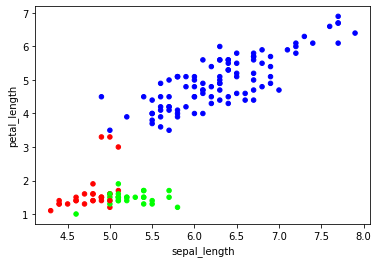

In [3]:
result = kmeans_clustering(data.iloc[:, :-1].values, 3)
data.plot.scatter(x='sepal_length', y='petal_length', c=[plt.cm.brg(x / 2.) for x in result['assignments']]);

### Question 1c: Testing K-means [40%]
Selecting the right number of clusters $K$ is a very challenging problem, especially when we don't have some side-information or domain expertise that can help us narrow down a few reasonable values for that parameter. 

In the absence of any other information, a very useful exercise is to create the plot of SSE (sum of squares of errors) as a function of $K$. Ideally, for a very small $K$, the error will be high (since we are trying to approximate a whole lot of points with a very small number of centroids) and as $K$ increases, the error decreases. However, after a certain value (or a couple of values) for $K$, we will notice diminishing returns, i.e., the error will be decreasing, but not to a great degree. Typically, the value(s) for $K$ where this behavior is observed (the threshold point after which we observe diminishing returns) is usually a good guess for the number of clusters. 

In this question, we will have to create the SSE vs. K plot for $K = 1\cdots10$. Furthermore, because K-means uses randomized initialization, we need to do a number of iterations per value of $K$ in order to get a good estimate of the actual SSE (which may not be caused by randomness in the initialization). For this question, you will have to run the entire K-means algorithm to completion, and repeat it 50 different times per $K$, and collect all SSEs. In the figure, you should report the mean SSE per $K$, surrounded by error-bars which will encode the standard deviation.

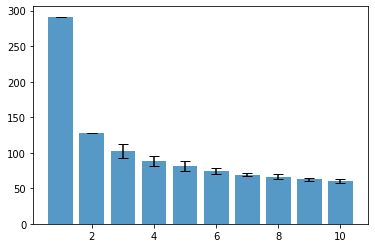

In [4]:
accuracies = [[kmeans_clustering(data.iloc[:, :-1].values, k)['all_sse'][-1] for _ in range(50)] for k in range(1, 11)]

average = [np.average(a) for a in accuracies]
std = [np.std(a) for a in accuracies]

plt.bar(np.arange(1,11), average, yerr=std, ecolor='black', capsize=5, alpha=0.75);